# Post-processing tool for tabular BLAST output

This notebook aims to simplify the analysis phase of the output obtained from the BLAST tool in tabular (tsv) format.
Simply enter the current parameters (where specified) in the editable fields to obtain customised analyses and graphs adapted to the input.

In [33]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log10, floor
import matplotlib.cm as cm

%matplotlib inline

#Useful function for displaying more data
def display_all(df):
    with pd.option_context("display.max_columns", 1000):
        display(df)

#Find the exponent of a float number in scientific notation
def find_exp(number) -> int:
    if abs(number) == 0:
        return 0
    base10 = log10(abs(number))
    return abs(floor(base10))

plt.rcParams['figure.dpi'] = 110

Import the dataset in tsv format and create a pandas dataframe.

In [34]:
#Insert the name (or path) of the tsv file
filename = "./salamandra/fast-slow.cds_sp.tsv"

#Insert the outformat
outformat = "qseqid qlen sseqid sallseqid slen qstart qend sstart send qseq full_qseq sseq full_sseq evalue bitscore score length pident nident mismatch positive gapopen gaps ppos qframe btop cigar staxids sscinames sskingdoms skingdoms sphylums stitle salltitles qcovhsp scovhsp qtitle qqual full_qqual qstrand"

#Import the dataset
df = pd.read_csv(filename, sep="\t", names=outformat.split())

#Insert the title of graph
title = "Salamandra_salamandra_Blastp-Swissprot"

#Filename for output
path = "./salamandra/" + title;

Run this cell only if you want to obtain the most significant feedback for each transcript.

In [36]:
df = df.groupby('qseqid').first().reset_index()

## Protein hits count analysis

Protein functions Hit-rate analysis section. This chart gives a listing of the top 15 different protein subjects.

#### Accession Graph

In [37]:
#Series with accession id and count
hits = df['sseqid'].value_counts()

#Insert the number of results (default 20)
results_number = 15

#Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(hits) > results_number:
    hits.drop(hits.tail(len(hits) - results_number).index, inplace=True)

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(hits)//2 - len(hits)//4 + 2))

#Sortting and adjusting data
hits.sort_values(inplace=True)
hits.reset_index(drop=True);

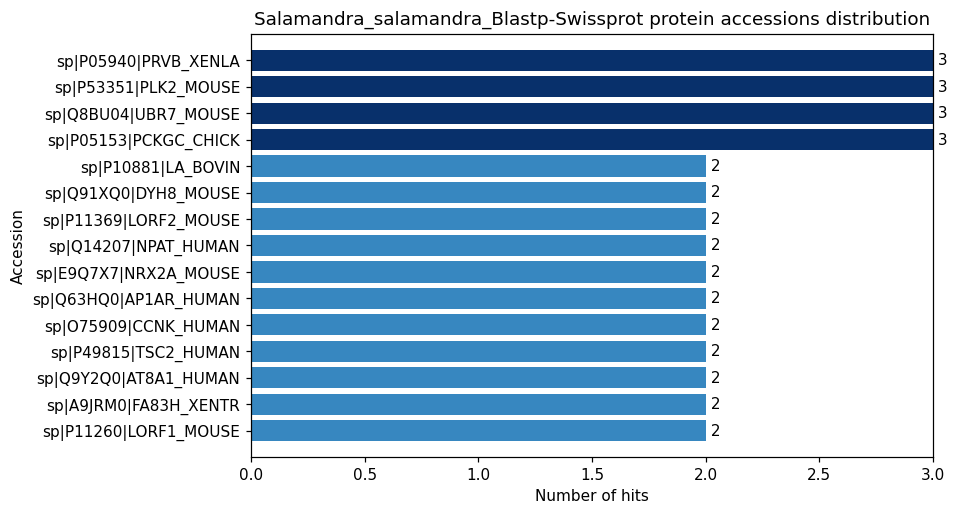

In [38]:
#Creating the graph with color
colors = cm.Blues(hits.values / float(max(hits.values)))
plt.barh(hits.index, hits.values, color=colors)
plt.ylim([-1,len(hits.index)])
plt.xlim([0, hits[-1] + hits.values[0]//5])

#Insert labels
for index, value in enumerate(hits.values):
    plt.text(value, index, " " + str(value), va='center')


plt.xlabel('Number of hits')
plt.ylabel('Accession')
plt.title(title + ' protein accessions distribution')

#Save and plot!
plt.savefig(path + '_protein_accessions.png', bbox_inches = 'tight', dpi=300)

plt.show()

#### Protein functions graph (NR)

In [11]:
def get_sciname(x):
    
    os_index = - x[::-1].index('[')

    return x[os_index:-1]

# Useful functions
def get_protein_function(x):

    x_l = x.split(" ")

    return ' '.join(x_l[1:x_l.index(next(x for x in x_l if x.startswith('[')))])

#### Protein functions graph (Swiss-Prot/TrEMBL)

In [39]:
def get_sciname(x):

    os_index = x.index('OS=')
    ox_index = x.index('OX=')

    return x[os_index+3:ox_index-1]

# Useful functions
def get_protein_function(x):

    x_l = x.split(" ")

    return ' '.join(x_l[1:x_l.index(next(x for x in x_l if x.startswith('OS=')))])

### Protein functions graph

In [40]:
# Creo due nuove colonne nel dataframe
df['protein_function'] = df['stitle'].apply(lambda x: get_protein_function(x))
df['scientific_name']  = df['stitle'].apply(lambda x: get_sciname(x))

#Series with accession id and count
proteins  = df['protein_function'].value_counts()
sci_names = df['scientific_name'].value_counts()

# Insert all index to remove from the plot
try:
    roteins = proteins.drop(['Uncharacterized protein'])
except:
    pass

#Insert the number of results
results_number = 15

#Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(proteins) > results_number:
    proteins.drop(proteins.tail(len(proteins) - results_number).index, inplace=True)

if len(sci_names) > results_number:
    sci_names.drop(sci_names.tail(len(sci_names) - results_number).index, inplace=True)

#Sorting and adjusting data
proteins.sort_values(inplace=True)
proteins.reset_index(drop=True)

sci_names.sort_values(inplace=True)
sci_names.reset_index(drop=True)
proteins.sort_values(ascending=True, inplace=True)

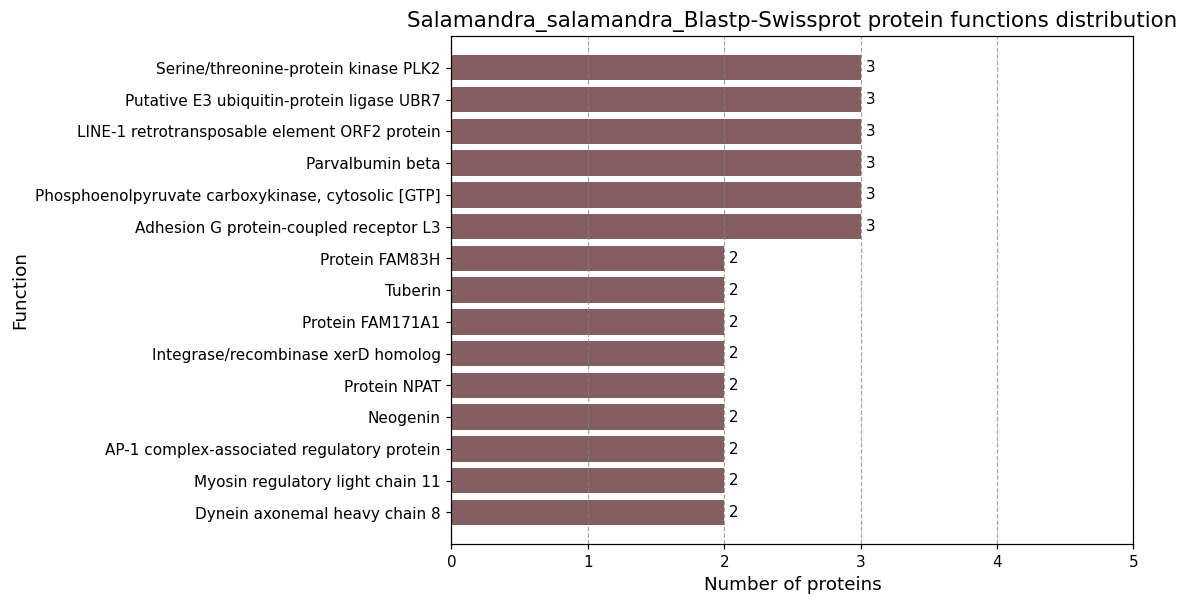

In [41]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(proteins.index, proteins.values, color='#855F5F')

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(proteins)//2 - len(proteins)//4 + 2))

# Set the x-axis and y-axis limits
ax.set_xlim([0, proteins[-1] + proteins.values[0]])
ax.set_ylim([-1, len(proteins.index)])

# Insert labels with values inside each bar
for index, value in enumerate(proteins.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of proteins', fontsize=12)
ax.set_ylabel('Function', fontsize=12)
ax.set_title(title + ' protein functions distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_protein_functions.png', bbox_inches = 'tight', dpi=300)
plt.show()

#### Scientific names graph

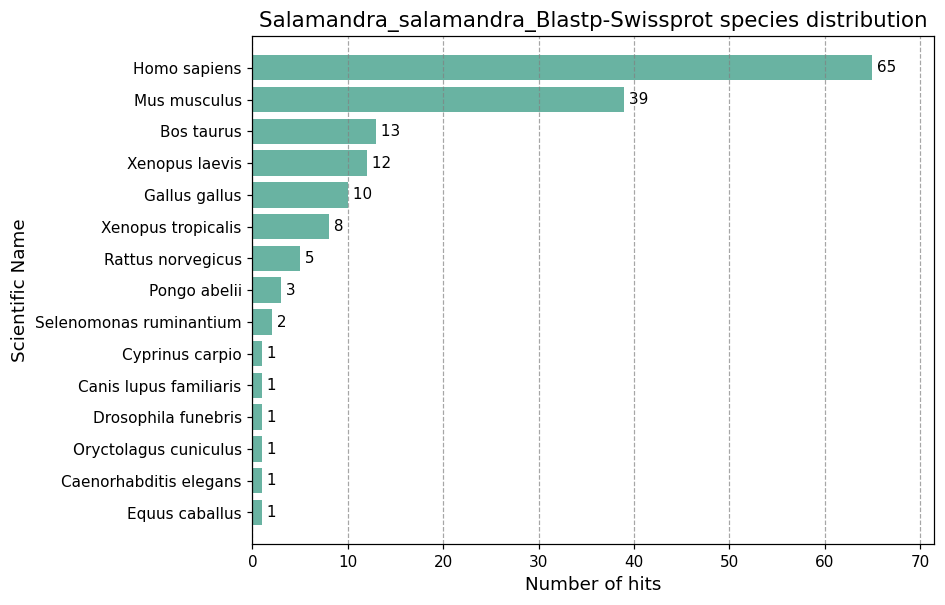

In [42]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(sci_names.index, sci_names.values, color='#69b3a2')

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(sci_names)//2 - len(sci_names)//4 + 2))

# Set the x-axis and y-axis limits
ax.set_xlim([0, sci_names.max() + sci_names.max()*0.1])
ax.set_ylim([-1, len(sci_names.index)])

# Insert labels with values inside each bar
for index, value in enumerate(sci_names.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of hits', fontsize=12)
ax.set_ylabel('Scientific Name', fontsize=12)
ax.set_title(title + ' species distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_species.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Sequences hits analysis

Hit-rate analysis section. This chart gives a listing of the different subjects to which most sequences were aligned during the BLAST step.

In [43]:
#Series with names and count
hits = df['qseqid'].value_counts()

#Insert the number of results (default 20)
results_number = 30

#Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(hits) > results_number:
    hits.drop(hits.tail(len(hits) - results_number).index, inplace=True)

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(hits)//2 - len(hits)//4 + 2))

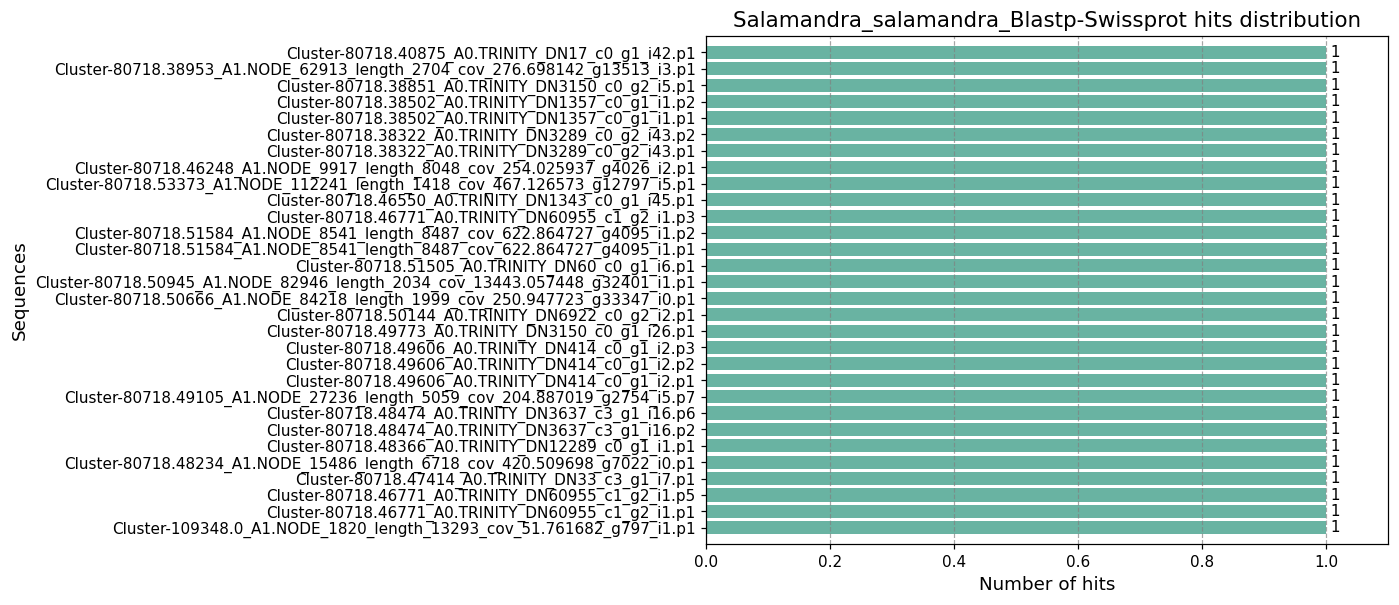

In [44]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(hits.index, hits.values, color='#69b3a2')

# Set the x-axis and y-axis limits
ax.set_xlim([0, hits.max() + hits.max()*0.1])
ax.set_ylim([-1, len(hits.index)])

# Insert labels with values inside each bar
for index, value in enumerate(hits.values):
    ax.text(value, index, " " + str(value), ha='left', va='center')

# Set axis labels and title
ax.set_xlabel('Number of hits', fontsize=12)
ax.set_ylabel('Sequences', fontsize=12)
ax.set_title(title + ' hits distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_hits.png', bbox_inches = 'tight', dpi=300)
plt.show()

## E-Value distribution

E-value analysis section.
This chart plots the distribution of E-values for all selected BLAST hits. It is useful to evaluate the success of the alignment for a given sequence database and help to adjust the E-Value cutoff in the annotation step.

In [45]:
#Series with e-value of subject sequenceid
evalues_series = df[["qseqid", "sseqid", "evalue"]].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

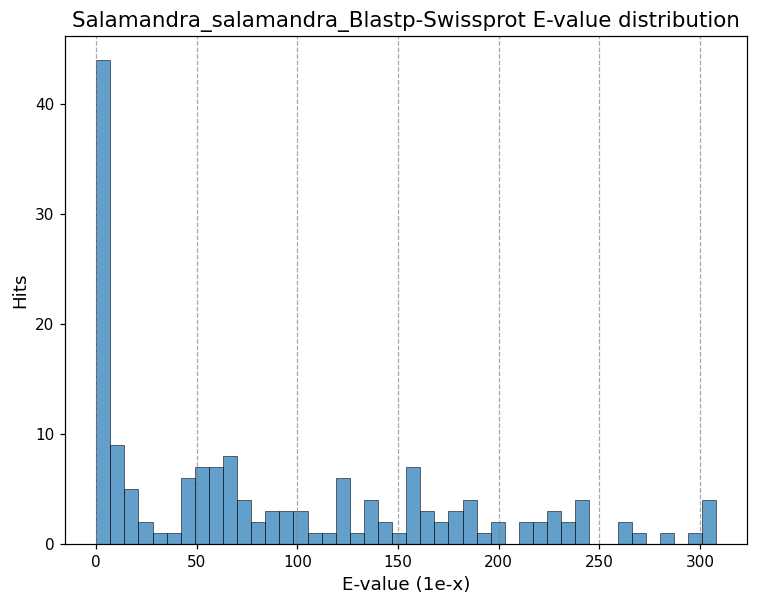

In [46]:
# Sort the DataFrame by e-value
evalues_series.sort_values(by=["evalue"], inplace=True, ascending=True)

# Create a list of exponents of all e-value of dataframe
evalues = list(evalues_series.evalue)
evalues = [np.format_float_scientific(x, precision=4, exp_digits=3) for x in evalues]
evalues_exp = [find_exp(float(x)) for x in evalues]

# Create the histogram with a color palette
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(evalues_exp, bins=[x for x in range(0, max(evalues_exp), max(evalues_exp)//40)], 
                           edgecolor='black', linewidth=0.5, alpha=0.7)

# Set the x-axis and y-axis limits
#ax.set_xlim([-40, 1])
#ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('E-value (1e-x)', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' E-value distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Save and display the chart
plt.savefig(path + '_evalue.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Bit-score distribution

Bit-score analysis section.

In [47]:
#Series with bit-score of subject sequenceid
bitscores = df[["qseqid", "sseqid", "bitscore"]].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

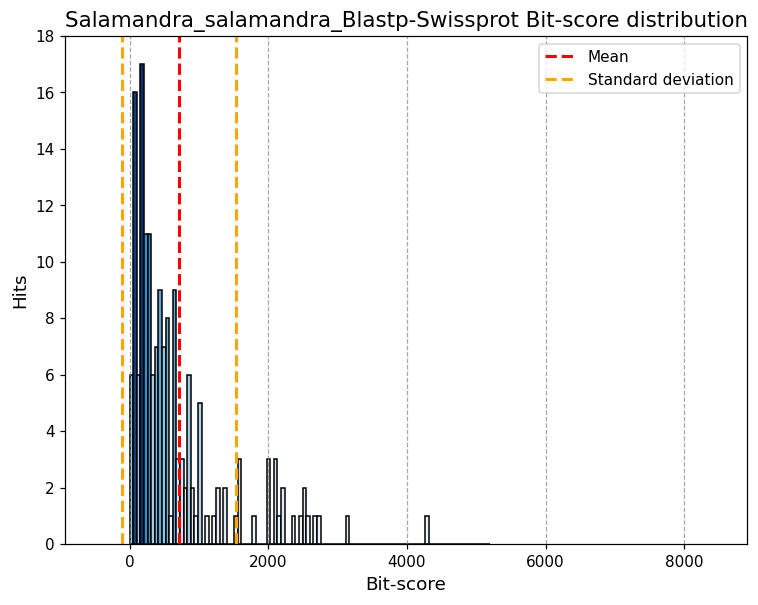

In [48]:
# Sorting by bit-score
bitscores.sort_values(["bitscore"], axis=0, inplace=True, ascending=True)

# Adjusting the indexes
bitscores.reset_index(drop=True, inplace=True)

# Create the histogram
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(bitscores.bitscore, bins=[x for x in range(0, int(max(bitscores.bitscore)), int(max(bitscores.bitscore))//100)], color='steelblue', edgecolor='black')

# Set the x-axis and y-axis limits
ax.set_xlim([0, max(bitscores.bitscore)])
ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('Bit-score', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' Bit-score distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Calculate mean and standard deviation
mean = bitscores.bitscore.mean()
std = bitscores.bitscore.std()

# Add mean and standard deviation lines
ax.axvline(mean, color='red', linestyle='--', linewidth=2)
ax.axvline(mean - std, color='orange', linestyle='--', linewidth=2)
ax.axvline(mean + std, color='orange', linestyle='--', linewidth=2)

# Adding the legend
plt.legend(['Mean', 'Standard deviation'])

# Set the color of each patch based on its height
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colormap = plt.cm.ScalarMappable(cmap='Blues')
colormap.set_clim(0, max(n))
for c, p in zip(colormap.to_rgba(n), patches):
    plt.setp(p, 'facecolor', c)

# Zoom in around the mean
ax.set_xlim([mean - 2*std, mean + 10*std])

# Save and display the chart
plt.savefig(path +'_bitscore.png', bbox_inches='tight', dpi=300)
plt.show()

## Length and Similarity distribution

Length and similarity analysis section.

### Length distribution

This chart displays the distribution of all calculated sequence lengths, shows the overall performance of the alignments and helps to adjust the annotation score in the annotation step.

In [49]:
#Series with length of subject sequenceid
length = df[["qseqid", "sseqid", "length"]].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

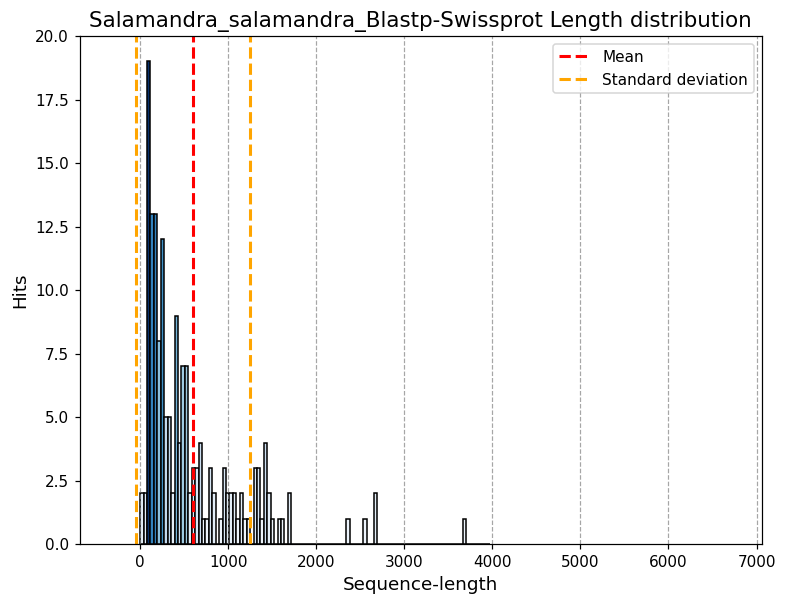

In [50]:
# Sorting by bit-score
length.sort_values(["length"], axis=0, inplace=True, ascending=True)

# Adjusting the indexes
length.reset_index(drop=True, inplace=True)

# Create the histogram
fig, ax = plt.subplots(figsize=(8, 6))
n, bins, patches = ax.hist(length.length, bins=[x for x in range(0, int(max(length.length)), int(max(length.length))//100)], color='steelblue', edgecolor='black')

# Set the x-axis and y-axis limits
ax.set_xlim([0, max(length.length)])
ax.set_ylim([0, max(ax.get_yticks())])

# Set axis labels and title
ax.set_xlabel('Sequence-length', fontsize=12)
ax.set_ylabel('Hits', fontsize=12)
ax.set_title(title + ' Length distribution', fontsize=14)

# Add grid lines
ax.xaxis.grid(color='gray', linestyle='--', alpha=0.7)

# Calculate mean and standard deviation
mean = length.length.mean()
std  = length.length.std()

# Add mean and standard deviation lines
ax.axvline(mean, color='red', linestyle='--', linewidth=2)
ax.axvline(mean - std, color='orange', linestyle='--', linewidth=2)
ax.axvline(mean + std, color='orange', linestyle='--', linewidth=2)

# Adding the legend
plt.legend(['Mean', 'Standard deviation'])

# Set the color of each patch based on its height
bin_centers = 0.5 * (bins[:-1] + bins[1:])
colormap = plt.cm.ScalarMappable(cmap='Blues')
colormap.set_clim(0, max(n))
for c, p in zip(colormap.to_rgba(n), patches):
    plt.setp(p, 'facecolor', c)

# Zoom in around the mean
ax.set_xlim([mean - 2*std, mean + 10*std])

# Save and display the chart
plt.savefig(path +'_lendistribution.png', bbox_inches='tight', dpi=300)
plt.show()

### Similarity distribution

This chart displays the distribution of all calculated sequence similarities (percentages), shows the overall performance of the alignments and helps to adjust the annotation score in the annotation step.

In [51]:
# Get the identity percentage
pidents = df[["qseqid", "pident"]].copy()

#Setting the figsize
plt.rcParams["figure.figsize"] = (5, 5)

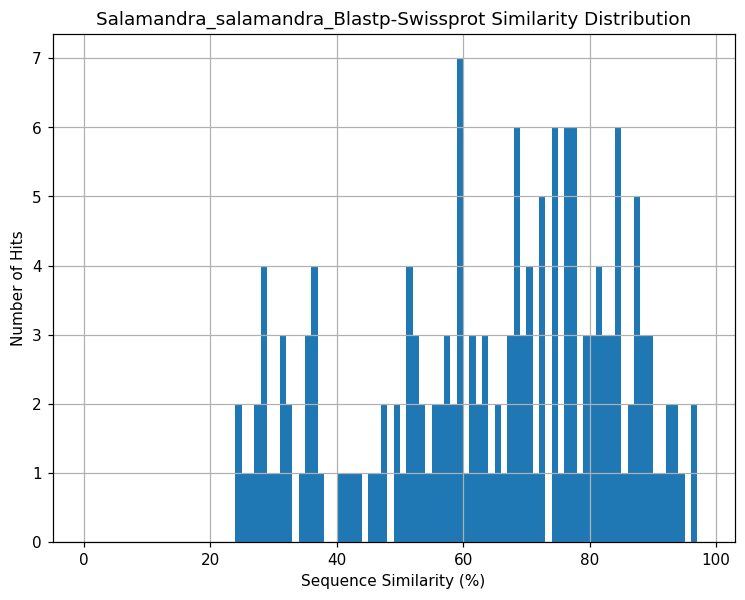

In [52]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Sort the data and create the histogram
pidents.sort_values(["pident"], axis=0, inplace=True, ascending=True)
pidents.reset_index(drop=True, inplace=True)
plt.hist(pidents.pident, bins=[x for x in range(0, max(int(max(pidents.pident)), 1), max(1, int(max(pidents.pident))//100))])

# Add labels and title
plt.xlabel('Sequence Similarity (%)')
plt.ylabel('Number of Hits')
plt.title(title + ' Similarity Distribution')

# Add a grid
plt.grid(True)

# Save and show the plot
plt.savefig(path + '_similarity.png', bbox_inches = 'tight', dpi=300)
plt.show()

## Species Distribution

Most represented species and gene product hits. Top 10 best species and protein hits present in the reference database.

In [53]:
#Get the scientific names of the organism from the output
scinames = df["sscinames"].value_counts()

#Sorting and adjust the indexes
scinames.sort_values(inplace=True)
scinames.reset_index(drop=True)

#Insert the number of results (default 20)
results_number = 20

#Drop the last len(h) - results_number lines, only if  len(h) > results_number
if len(scinames) > results_number:
    scinames.drop(scinames.head(len(scinames) - results_number).index, inplace=True)

#Set appropriate figsize
plt.rcParams["figure.figsize"] = (8, min(results_number//2 - results_number//4 + 1, len(scinames)//2 - len(scinames)//4 + 2))

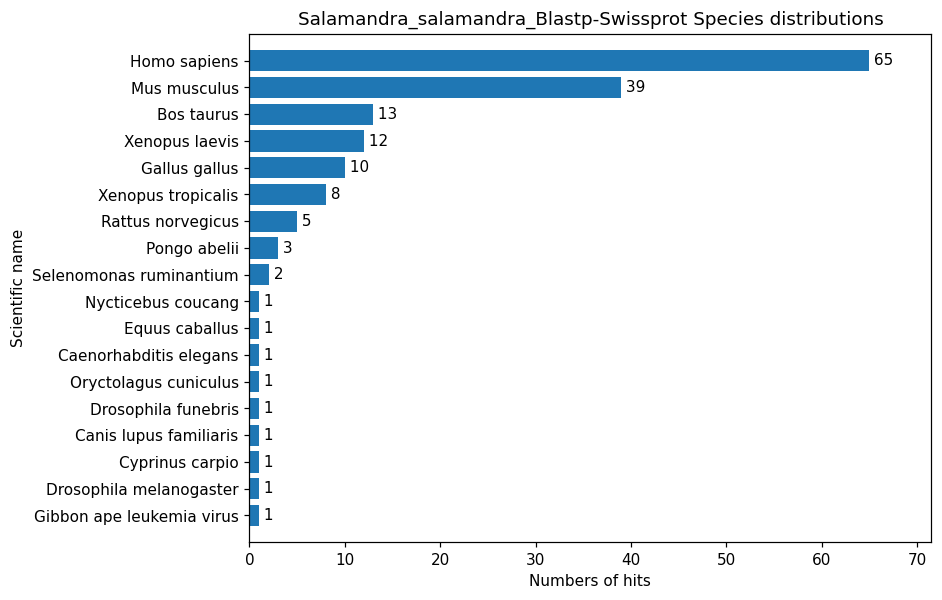

In [54]:
#Adjust the axis limits
plt.ylim([-1,len(scinames.index)])
plt.xlim([0, scinames.max() + scinames.max()*0.1])

#Insert lables
for index, value in enumerate(scinames.values):
    plt.text(value, index, " " + str(value), va='center')

#Adding proper labels
plt.xlabel('Numbers of hits')
plt.ylabel('Scientific name')
plt.title(title + ' Species distributions')

#Plot!
plt.barh(scinames.index, scinames.values)
plt.savefig(path + '_species2.png', bbox_inches = 'tight', dpi=350)
plt.show()